This tutorial is derived from the object detection tutorial available at https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb .

("Speed/accuracy trade-offs for modern convolutional object detectors."
Huang J, Rathod V, Sun C, Zhu M, Korattikara A, Fathi A, Fischer I, Wojna Z,
Song Y, Guadarrama S, Murphy K, CVPR 2017)

Images are 

## Library Import

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import csv

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image


In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
sys.path.append("google_object_detection_utils/")
from utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util
from object_detection_utils import *

## Detection Model Download

In [4]:
# These models can be donwloaded from the website of Google Detection API
MODEL_NAMES = [
    'ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03',
    'ssd_mobilenet_v1_coco_2018_01_28',
    'ssd_mobilenet_v2_coco_2018_03_29',
    'ssd_inception_v2_coco_2018_01_28',
    'faster_rcnn_inception_v2_coco_2018_01_28'
]

DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

PATH_TO_LABELS = os.path.join('google_object_detection_utils/data/mscoco_label_map.pbtxt')

In [5]:
detection_graphs = load_models_from_Google_API(MODEL_NAMES, DOWNLOAD_BASE)

ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03.tar.gz is already downloaded.
ssd_mobilenet_v1_coco_2018_01_28.tar.gz is already downloaded.
ssd_mobilenet_v2_coco_2018_03_29.tar.gz is already downloaded.
ssd_inception_v2_coco_2018_01_28.tar.gz is already downloaded.
faster_rcnn_inception_v2_coco_2018_01_28.tar.gz is already downloaded.
All models loaded


In [6]:
# Load the dictionary for looking up label names
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [7]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
IMAGE_NAMES = os.listdir(PATH_TO_TEST_IMAGES_DIR)
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name) for image_name in IMAGE_NAMES]

In [8]:
image_nps = load_images_as_np_array(TEST_IMAGE_PATHS)

In [9]:
outputs = {}
for k in detection_graphs:
    outputs[k] = detect_by_model(image_nps, detection_graphs[k])

Predicted:1
Predicted:2
Predicted:3
Predicted:1
Predicted:2
Predicted:3
Predicted:1
Predicted:2
Predicted:3
Predicted:1
Predicted:2
Predicted:3
Predicted:1
Predicted:2
Predicted:3


## Post Processing

In [10]:
all_boxes, all_classes = combine_with_IoU(outputs)
all_classes = [np.array(a, dtype=int) for a in all_classes]
all_boxes, all_classes

([array([[0.47437015, 0.36914742, 0.8392021 , 0.4699279 ]], dtype=float32),
  array([[0.4978609 , 0.01403295, 0.8159853 , 0.13964045],
         [0.31443417, 0.16748127, 0.7224548 , 0.98527926]], dtype=float32),
  array([[7.2460331e-02, 1.7123152e-01, 9.1819704e-01, 7.9035121e-01],
         [6.2009320e-04, 7.2748220e-01, 5.1609945e-01, 9.1616637e-01],
         [5.2020885e-04, 3.9836388e-02, 6.0150856e-01, 3.1389993e-01],
         [4.1364223e-01, 3.2185602e-01, 5.6403458e-01, 5.3325075e-01],
         [5.1661855e-01, 3.5269004e-01, 5.6536335e-01, 4.0065265e-01],
         [5.1867962e-03, 0.0000000e+00, 7.8325808e-02, 9.5431991e-02],
         [5.9760872e-02, 3.0027997e-01, 7.6668441e-01, 5.9032130e-01]],
        dtype=float32)],
 [array([[1, 1, 1, 1, 1]]), array([[1, 1, 1, 1, 1],
         [3, 3, 3, 3, 3]]), array([[ 1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1],
         [39,  0,  0,  0, 39],
         [ 0,  0,  0, 37,  0],
         [ 0,  0,  0,  0,  1],
  

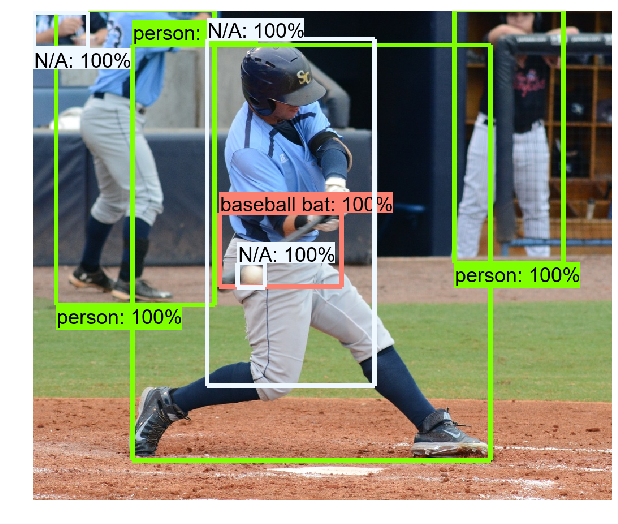

In [26]:
im_id = 2
model_id = 0
test_output_dict = {
    'num_detections': len(all_boxes[im_id]),
    'detection_boxes': all_boxes[im_id],
    'detection_scores': np.ones(len(all_boxes[im_id]), dtype=int),
    'detection_classes': np.array(all_classes[im_id][:, model_id], dtype=int)
}
display_results(image_nps[im_id], test_output_dict, min_score_thresh=0.1, category_index=category_index)

## Snorkel

In [12]:
%load_ext autoreload
%autoreload 2
import os
from snorkel import SnorkelSession
session = SnorkelSession()
from scipy import sparse
from snorkel.learning import GenerativeModel

In [13]:
L = np.concatenate(all_classes)
L.shape

(10, 5)

In [14]:
L_train = sparse.csr_matrix(L)
gen_model = GenerativeModel()
gen_model.train(L_train, cardinality=90)

In [15]:
train_marginals = gen_model.marginals(L_train)
assert np.all(train_marginals.sum(axis=1) - np.ones(L.shape[0]) < 1e-10)

In [16]:
num_array = np.array([len(a) for a in all_boxes])
index_array = []
temp = 0
for num in num_array:
    temp += num
    index_array.append(temp)
train_marginals_split = np.split(train_marginals, index_array)

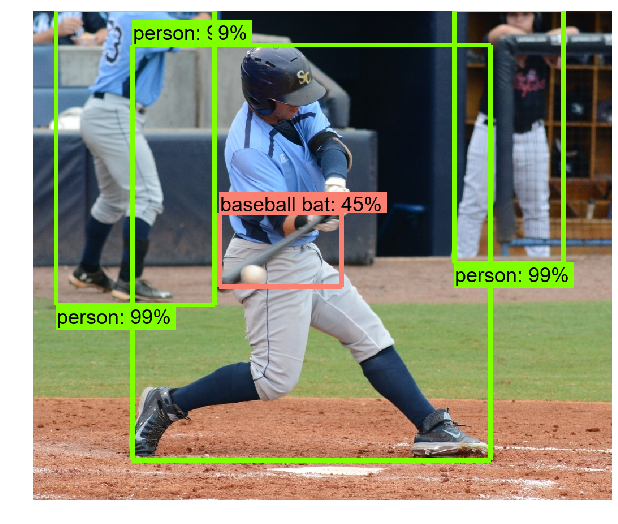

In [27]:
im_id = 2
test_output_dict = {
    'num_detections': len(all_boxes[im_id]),
    'detection_boxes': all_boxes[im_id],
    'detection_scores': np.ones(len(all_boxes[im_id]), dtype=int),
    'detection_classes': train_marginals_split[im_id]
}
display_results(image_nps[im_id], test_output_dict, min_score_thresh=0.1, multiple_label=True, category_index=category_index)

## Open Image Dataset

Please first obtain the dataset from https://storage.googleapis.com/openimages/web/download.html

### Annotation Mapping

In [18]:
annotations_path = 'data/class-descriptions-boxable.csv'
category_index_2 = {}
with open(annotations_path, 'r') as annofile:
    for row in csv.reader(annofile):
        category_index_2[row[0]] = {'id':row[0], 'name':row[1]}

invert_category_index = dict([(d['name'],d['id']) for d in category_index.values()])
conversion_coco_opi = [(invert_category_index[d['name'].lower()], d['id'], d['name'].lower()) for d in category_index_2.values() if d['name'].lower() in invert_category_index]

In [19]:
test_images_names = [os.path.splitext(os.path.basename(path))[0] for path in TEST_IMAGE_PATHS]
test_images_names_dict = dict([(test_images_names[i], i) for i in range(len(test_images_names))])

In [20]:
opi_to_coco = dict([(oid, cid) for cid, oid, name in conversion_coco_opi])
coco_to_opi = dict([(cid, oid) for cid, oid, name in conversion_coco_opi])

In [21]:
test_images_boxes = [[] for _ in range(len(TEST_IMAGE_PATHS))] 
test_images_classes = [[] for _ in range(len(TEST_IMAGE_PATHS))] 
path_to_annotations = 'data/validation-annotations-bbox.csv'
with open(path_to_annotations, 'r') as annofile:
    for row in csv.reader(annofile):
        if row[0] in test_images_names_dict and row[2] in opi_to_coco:
            im_id = test_images_names_dict[row[0]]
            (test_images_classes[im_id]).append(row[2])
            (test_images_boxes[im_id]).append([float(row[6]), float(row[4]), float(row[7]), float(row[5])])
test_images_boxes = [np.array(l) for l in test_images_boxes]

In [22]:
convert_cat_2 = dict([(k, i) for i, k in enumerate(category_index_2.keys())])
category_index_2_convert = {}
for k in category_index_2.keys():
    category_index_2_convert[convert_cat_2[k]] = {'id': convert_cat_2[k], 'name': category_index_2[k]['name']}
test_images_classes = [[convert_cat_2[e] for e in l] for l in test_images_classes]

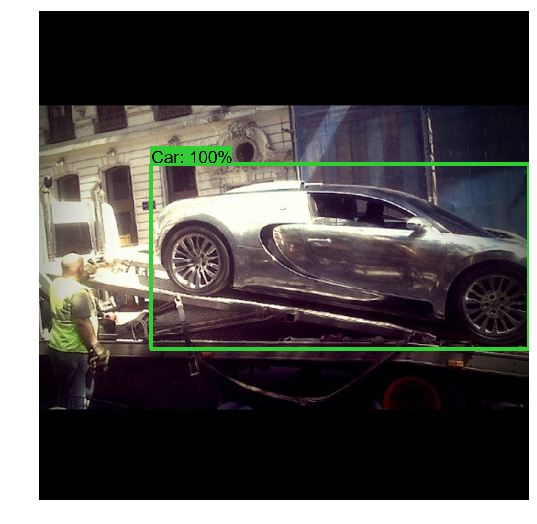

In [25]:
im_id = 1
test_output_dict = {
    'num_detections': len(test_images_boxes[im_id]),
    'detection_boxes': test_images_boxes[im_id],
    'detection_scores': np.ones(len(test_images_boxes[im_id]), dtype=int),
    'detection_classes': test_images_classes[im_id]
}
# print(test_output_dict)
display_results(image_nps[im_id], test_output_dict, min_score_thresh=0.1, category_index=category_index_2_convert)